Here I preprocess the raw data again 
- additionally - standard deviations, means, max, mins, protein mean pathogenicity 
- normalization of ESM1b data - global - read paper thoroughly and how did the AlphaMissense normalized the scores.
- pick high pathogenic variants per residue above certain threshold and analyze their scale values of AAclust 

### Imports and data pathways

In [1]:
import os  # Only if file operations are needed
import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm


In [2]:
os.chdir("/Users/doma/Documents/Bachelor_Arbeit/Code") 
# 1. Set up paths relative to notebook location
project_root = Path.cwd()  # assumes you run the notebook from /Code

esm_pathway = project_root / "data" / "raw" / "ALL_hum_isoforms_ESM1b_LLR"
amiss_pathway = project_root / "data" / "raw" / "AlphaMissense_csv"
human_nout_proteome_pathway = project_root / "data" / "processed" / "Human_N_Out_Proteome.csv"
all_esm1b_proteins_fp = project_root / "data" / "raw" / "000_uniprot_df.csv"

# 2. Load protein list
all_esm1b_proteins = pd.read_csv(all_esm1b_proteins_fp)
human_nout_proteome = pd.read_csv(human_nout_proteome_pathway)


### Normalization of ESM1b LLR Scores

#### Code to find the lowest LLR score

In [54]:
# find the most pathogenic LLR score in random .csv files in esm_pathway
# Select 1000 random entries from all_esm1b_proteins
random_entries = all_esm1b_proteins.sample(n=1000, random_state=42)['id']

# Initialize a variable to store the highest score
highest_score = 0

# Iterate over the selected entries again to find the highest score in the matrix
for entry in random_entries:
    esm_file_path = os.path.join(esm_pathway, f"{entry}_LLR.csv")
    
    if os.path.exists(esm_file_path):
        esm_data = pd.read_csv(esm_file_path, index_col=0)
        
        # Update the highest score if a higher score is found
        highest_score = min(highest_score, esm_data.to_numpy().min())

print(f"Highest score among all matrices: {highest_score}")


Highest score among all matrices: -29.592


#### Code to find 1st and 99th percentile of ESM1b global LLR scores

In [4]:
# Calculate the 1st and 99th percentile 
n = 1000  # You can adjust the value of n as needed
selected_entries = all_esm1b_proteins.sample(n, random_state=42)['id']

# Initialize a list to store all scores
all_scores = []

# Iterate over the selected entries and collect scores
for entry in selected_entries:
    esm_file_path = os.path.join(esm_pathway, f"{entry}_LLR.csv")
    
    if os.path.exists(esm_file_path):
        esm_data = pd.read_csv(esm_file_path, index_col=0)

        # Flatten and filter out zeros
        scores = esm_data.to_numpy().flatten()

        # Exclude LLR=0 values
        scores_nonzero = scores[scores != 0]
        all_scores.extend(scores_nonzero)



# Calculate the 1st and 99th percentiles
percentile_1 = np.percentile(all_scores, 0.5)
percentile_99 = np.percentile(all_scores, 99.5)
percentile_5 = np.percentile(all_scores, 5)
print(f"0.5th Percentile: {percentile_1:.2f}, 99.5th Percentile: {percentile_99:.2f}, 5th Percentile: {percentile_5:.2f}")

0.5th Percentile: -20.60, 99.5th Percentile: -0.65, 5th Percentile: -17.24


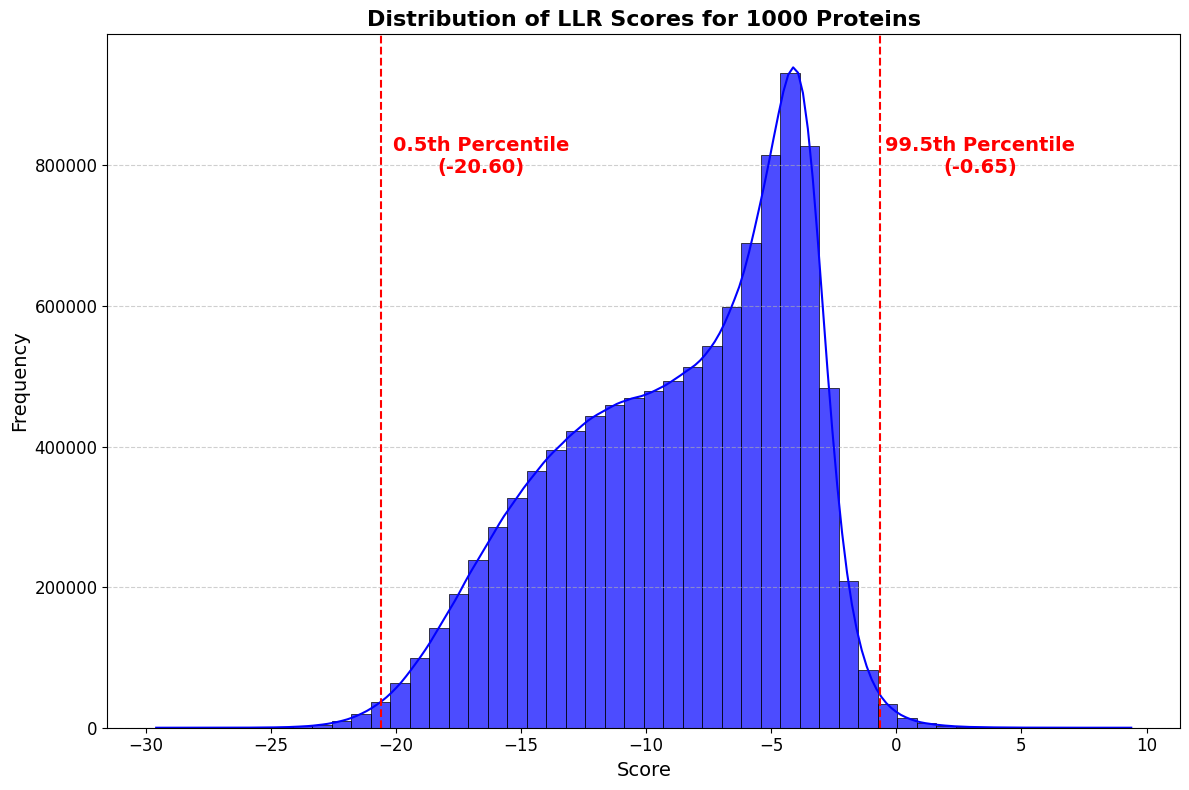

0.5th Percentile: -20.60, 99.5th Percentile: -0.65


In [73]:
# Plot the distribution of scores
plt.figure(figsize=(12, 8))
sns.histplot(all_scores, bins=50, kde=True, color='blue', alpha=0.7, edgecolor='black', linewidth=0.5)
plt.axvline(percentile_1, color='red', linestyle='--', linewidth=1.5, label='1st Percentile')
plt.axvline(percentile_99, color='red', linestyle='--', linewidth=1.5, label='99th Percentile')

# Add annotations for percentiles
plt.text(percentile_1 + 4, plt.ylim()[1] * 0.8, f"0.5th Percentile\n({percentile_1:.2f})", color='red', fontsize=14, ha='center', fontweight='bold')
plt.text(percentile_99 + 4, plt.ylim()[1] * 0.8, f"99.5th Percentile\n({percentile_99:.2f})", color='red', fontsize=14, ha='center', fontweight='bold')

# Improve aesthetics
plt.title(f'Distribution of LLR Scores for {n} Proteins', fontsize=16, fontweight='bold')
plt.xlabel('Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()

# Print percentiles
print(f"0.5th Percentile: {percentile_1:.2f}, 99.5th Percentile: {percentile_99:.2f}")

Abbildung, die normalizierung erklärt und die 
Alphamissense mappen auf die Kategorien von Clinvar 

esm1b pathogen threshold 
esm1b 

#### Normalization Step

In [75]:
print(f"0.5th Percentile: {percentile_1:.2f}, 99.5th Percentile: {percentile_99:.2f}")

# now take all the 1500 proteins ['entry'] from human_nout_proteome and normalize every
# LLR score and create new normalized .csv file in another folder 

save_folder = project_root / "data" / "processed" / "ESM1b_LLR_Normalized_Human_Nout_Proteome"
esm1b_missing_entries = []


# Exclude zero: if value == 0, keep it; else, normalize
def normalize_llr(x):
    if x == 0:
        return np.nan   # or np.nan if you want to mask it!
    else:
        return round((percentile_99 - x) / (percentile_99 - percentile_1), 7)



for entry in tqdm(human_nout_proteome['entry'], desc="Normalizing proteins"):

    esm_protein_path = os.path.join(esm_pathway, f"{entry}_LLR.csv" )

    if os.path.exists(esm_protein_path):

        # load the dataframe
        protein = pd.read_csv(esm_protein_path)

        # all columns without the first label one
        cols_to_normalize = protein.columns[1:]

       
        # for each element in esm1b protein pd apply normalization
        protein[cols_to_normalize] = protein[cols_to_normalize].map(normalize_llr)
            

        # Save the normalized file
        protein.to_csv(save_folder / f"{entry}_normalized.csv", index=False)
        print(f"Protein {entry} was successfully normalized")


    else:
        print(f"Protein {entry} is not in ESM1b database")
        esm1b_missing_entries.append(entry)



pd.DataFrame({'missing_entry': esm1b_missing_entries}).to_csv(
    save_folder / "esm1b_missing_entries.csv", index=False
    )


0.5th Percentile: -20.60, 99.5th Percentile: -0.65


Normalizing proteins:   0%|          | 0/1534 [00:00<?, ?it/s]

Protein P16150 was successfully normalized
Protein P28827 was successfully normalized
Protein P10586 was successfully normalized
Protein Q06418 was successfully normalized
Protein P54764 was successfully normalized
Protein P19022 was successfully normalized
Protein O60469 was successfully normalized
Protein Q14118 was successfully normalized
Protein P09603 was successfully normalized
Protein P23468 was successfully normalized
Protein Q9UM47 was successfully normalized
Protein Q04721 was successfully normalized
Protein P05067 was successfully normalized
Protein P12830 was successfully normalized
Protein Q06481 was successfully normalized
Protein O14522 was successfully normalized
Protein P08581 was successfully normalized
Protein P22223 was successfully normalized
Protein Q86VB7 was successfully normalized
Protein Q15303 was successfully normalized
Protein Q15223 was successfully normalized
Protein Q9HCJ2 was successfully normalized
Protein Q8TD84 was successfully normalized
Protein P04

#### Pipeline for both Models
  compute:
  - standard deviation, varianz, mean, median, max, min per residue
  - the 10 most pathogenic variants per TMD-JMD region
  - per  

In [ ]:
# Define function 